In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from stock_LSTM import StockLSTM
from dataset_creation import StockDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
base_path = "price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [6]:
stock_prices = df["Close"].values
train_data, test_data = train_test_split(stock_prices, test_size=0.2, shuffle=False)

In [8]:
# Normalize the data
min_price = train_data.min()
max_price = train_data.max()

# Normalize training and testing data
train_data = (train_data - min_price) / (max_price - min_price)
test_data = (test_data - min_price) / (max_price - min_price)

In [9]:
seq_len = 5
train_dataset = StockDataset(train_data, seq_len)
test_dataset = StockDataset(test_data, seq_len)

In [14]:
test_dataset[0]

(tensor([0.6727, 0.6723, 0.6809, 0.6441, 0.6131]), tensor(0.6431))

In [12]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = StockLSTM(input_size=1, hidden_size=128, num_layers=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [13]:
# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(-1)
        targets = targets.float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(-1)
        targets = targets.float()

        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

/home/giorgos-tsouderos/miniconda3/envs/thesis_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/giorgos-tsouderos/miniconda3/envs/thesis_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 0.05852566286921501
Epoch 2/50, Loss: 0.08371272683143616
Epoch 3/50, Loss: 0.052592966705560684
Epoch 4/50, Loss: 0.10745000094175339
Epoch 5/50, Loss: 0.07703503966331482
Epoch 6/50, Loss: 0.09711732715368271
Epoch 7/50, Loss: 0.07996734231710434
Epoch 8/50, Loss: 0.0652841255068779
Epoch 9/50, Loss: 0.06679433584213257
Epoch 10/50, Loss: 0.07105420529842377
Epoch 11/50, Loss: 0.08982448279857635
Epoch 12/50, Loss: 0.11780156195163727
Epoch 13/50, Loss: 0.056620121002197266
Epoch 14/50, Loss: 0.10493162274360657
Epoch 15/50, Loss: 0.07688020169734955
Epoch 16/50, Loss: 0.047173015773296356
Epoch 17/50, Loss: 0.11661282181739807
Epoch 18/50, Loss: 0.10800004005432129
Epoch 19/50, Loss: 0.13718140125274658
Epoch 20/50, Loss: 0.1254539042711258
Epoch 21/50, Loss: 0.07245249301195145
Epoch 22/50, Loss: 0.11609623581171036
Epoch 23/50, Loss: 0.10549739748239517
Epoch 24/50, Loss: 0.04951610043644905
Epoch 25/50, Loss: 0.07740601897239685
Epoch 26/50, Loss: 0.033148489892

In [15]:
# Denormalize predictions
predictions = [p * (max_price - min_price) + min_price for p in predictions]
actuals = [a * (max_price - min_price) + min_price for a in actuals]

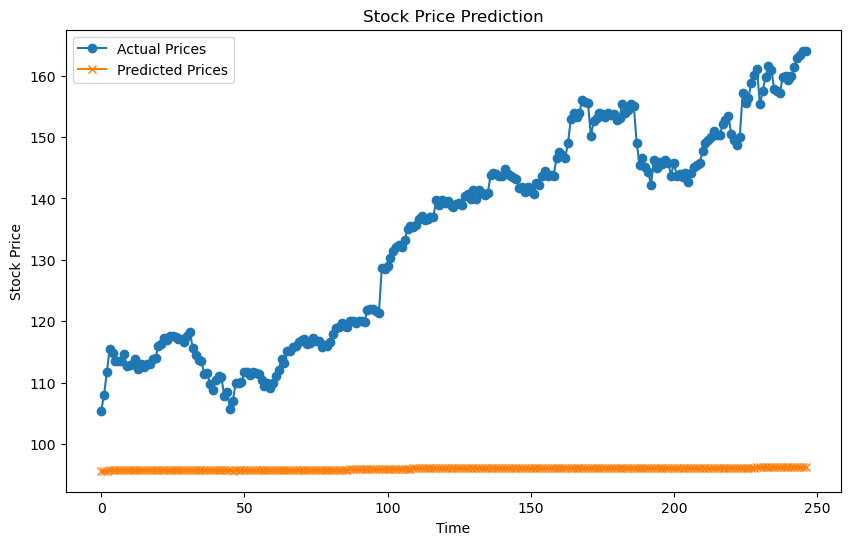

In [16]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()